In [27]:
require(data.table)
require(dplyr)
require(tidyverse)
require(dada2)
require(phyloseq)
require(genefilter)
require(ggplot2)
require(vegan)
require(RColorBrewer)
require(metacoder)
options(repr.plot.width=20, repr.plot.height=15)

Loading required package: dada2

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘dada2’”


In [28]:
ps<-readRDS(file = "/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/RDS/ps.rds")
#removing any taxa that don't show up in any samples to speed up the process
ps <- prune_taxa(taxa_sums(ps) > 0, ps)

In [29]:
#normalizing ps by converting rawcounts into relative abundances
#so samples with more reads wont be over represented
#using ps bc only to the count data (OTU table), while preserving the rest of the object
ps_norm = transform_sample_counts(ps, function(x) 1E6 * x / sum(x))

In [30]:
#isolate just bacteria
ps_norm_bac=subset_taxa(ps_norm, Kingdom=="Bacteria")
ps_norm_bac

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 82630 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95314 sample variables ]
tax_table()   Taxonomy Table:    [ 82630 taxa by 6 taxonomic ranks ]

In [31]:
#remove chloroplast order
ps_norm_nochlo=subset_taxa(ps_norm_bac, Order!="Chloroplast")
ps_norm_nochlo

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 60624 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95314 sample variables ]
tax_table()   Taxonomy Table:    [ 60624 taxa by 6 taxonomic ranks ]

In [32]:
theme_set(theme_bw())

In [33]:
#choosing plot colors 
mycolors= colorRampPalette(brewer.pal(8, "Set3"))(4)

### plot no chloroplast using glom

comparing Date_16S

In [8]:
ps_norm_nochlo_glom=tax_glom(ps_norm_nochlo, taxrank="Order")

In [9]:
top10 <- names(sort(taxa_sums(ps_norm_nochlo_glom), decreasing=TRUE))[1:10] 
#ps.top20 <- transform_sample_counts(ps_norm, function(OTU) OTU/sum(OTU)) 
ps_norm_nochlo_glom_top10 <- prune_taxa(top10, ps_norm_nochlo_glom) 

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the phyloseq package.
  Please report the issue at <https://github.com/joey711/phyloseq/issues>.”


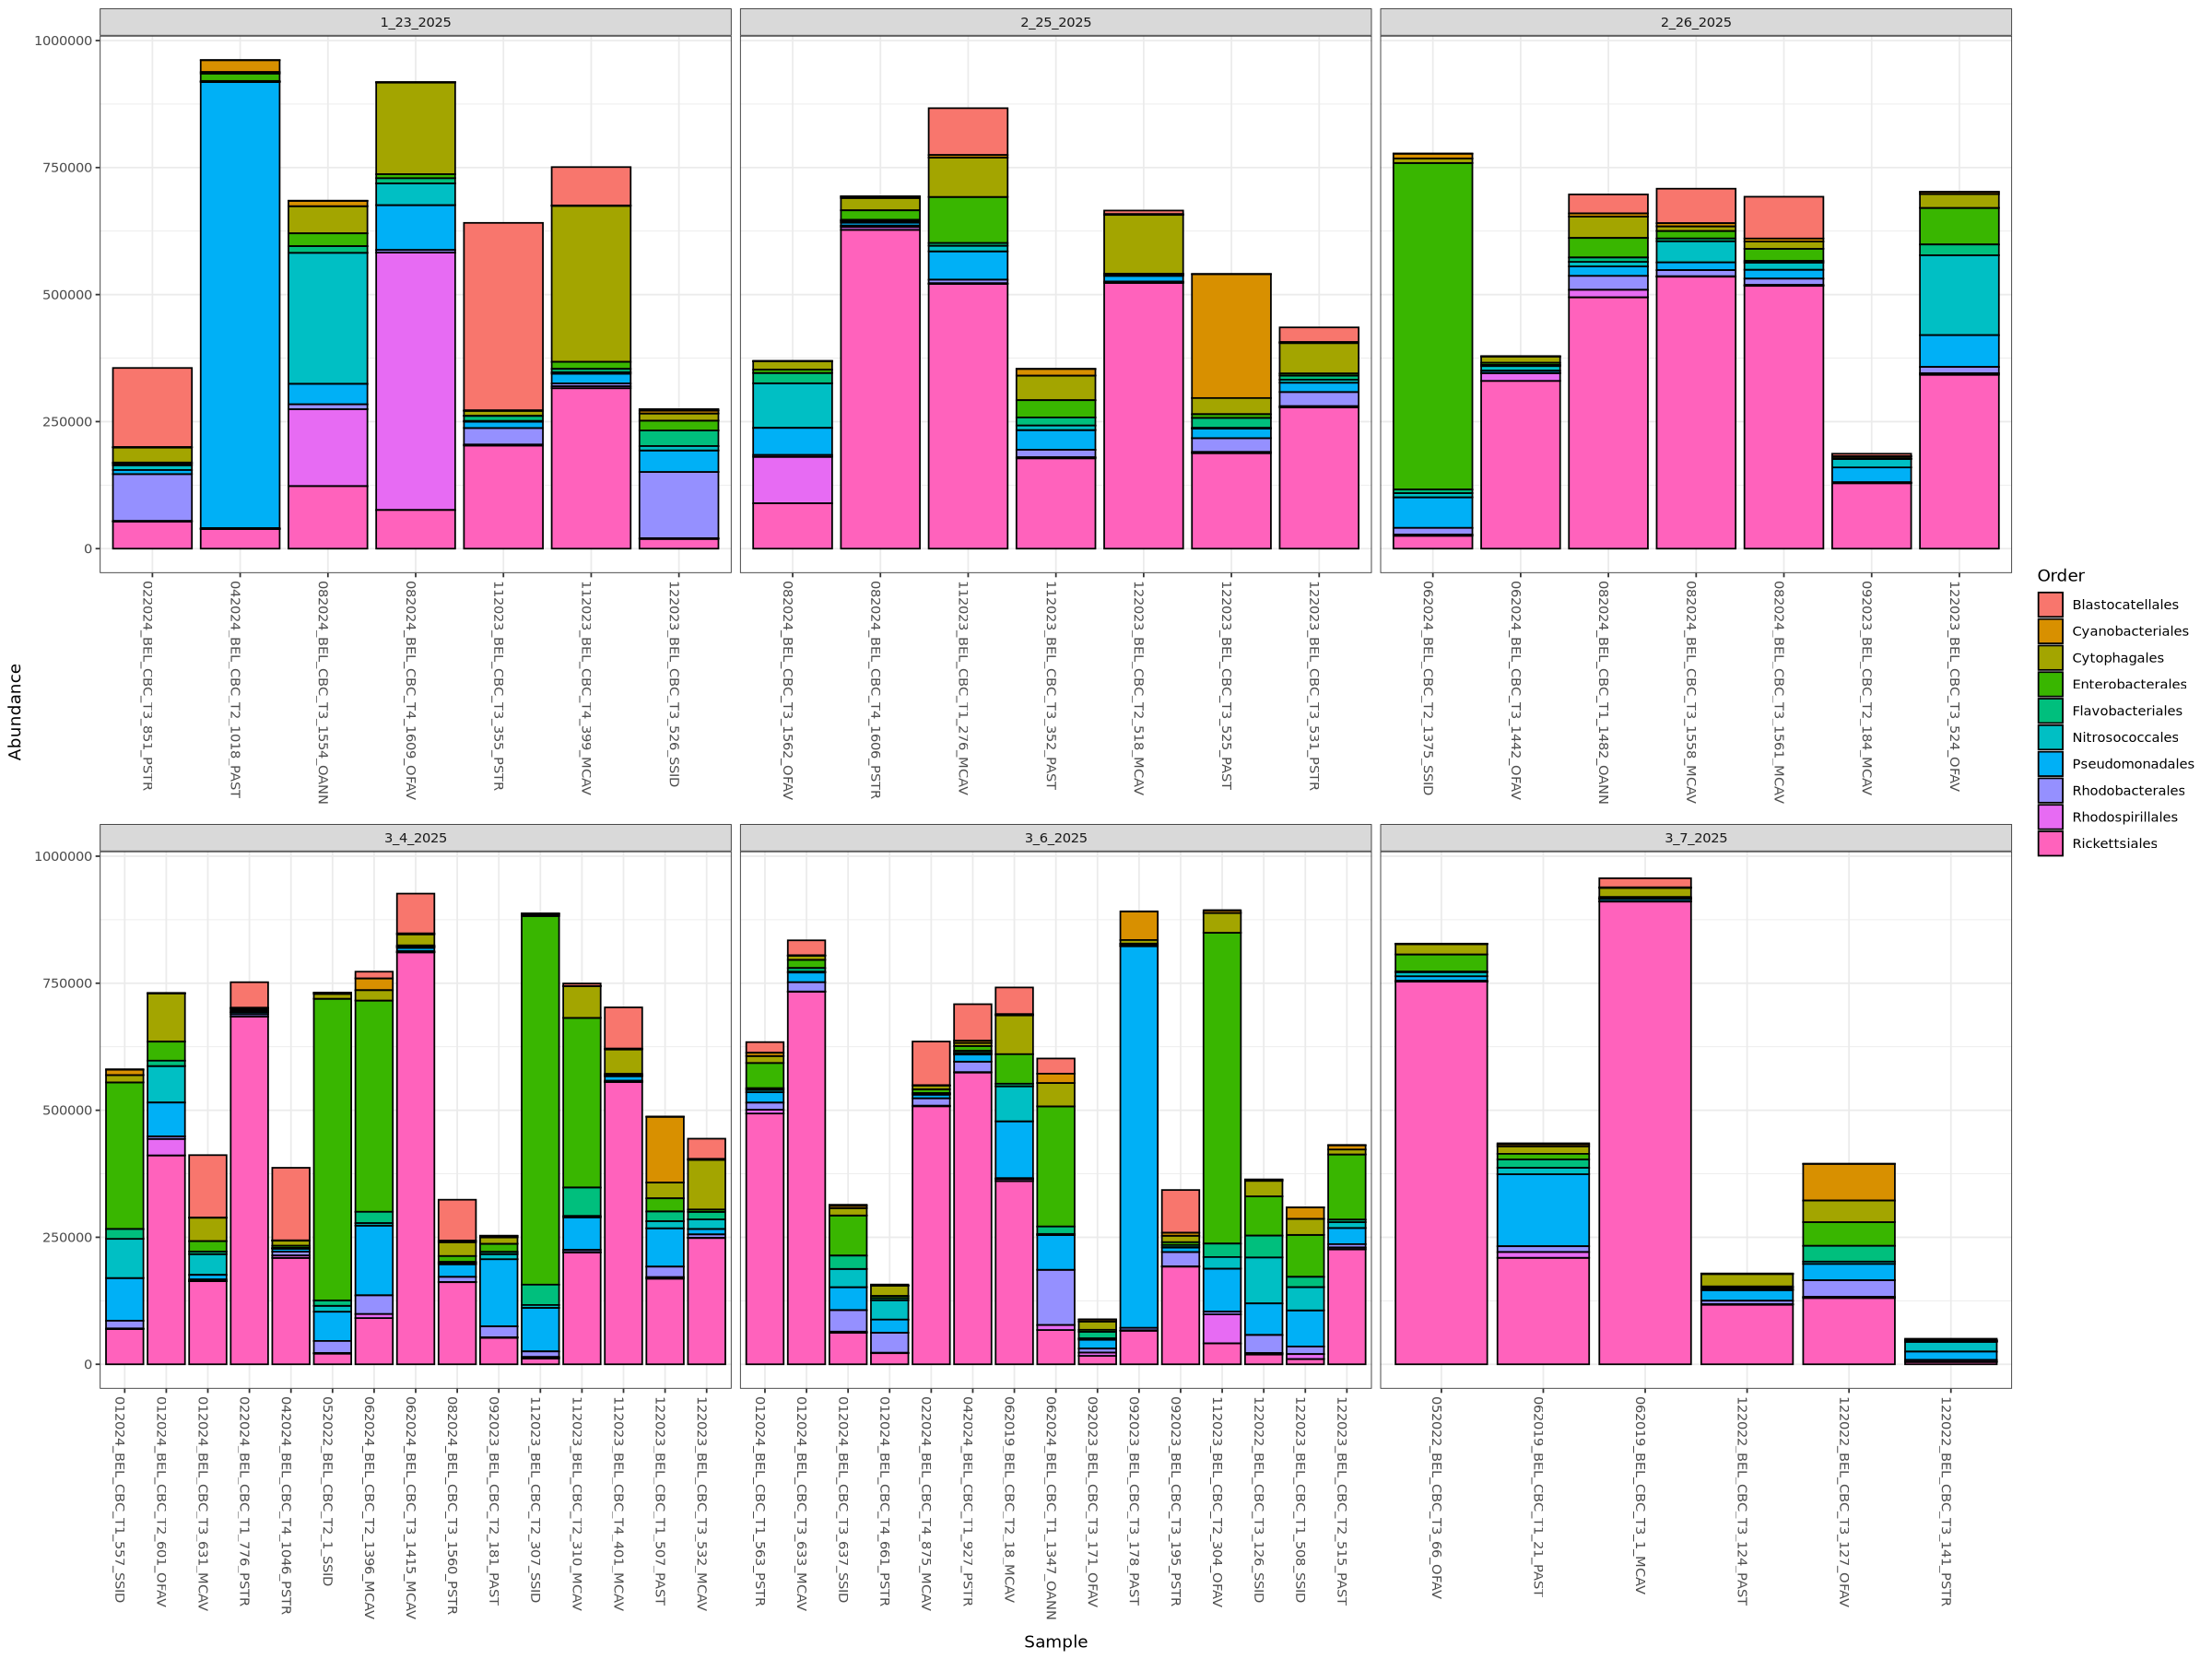

In [10]:
plot_bar(ps_norm_nochlo_glom_top10, fill="Order")+ facet_wrap(~Date_16S, scales="free_x")

### plot no chloroplast without glom
comparing species

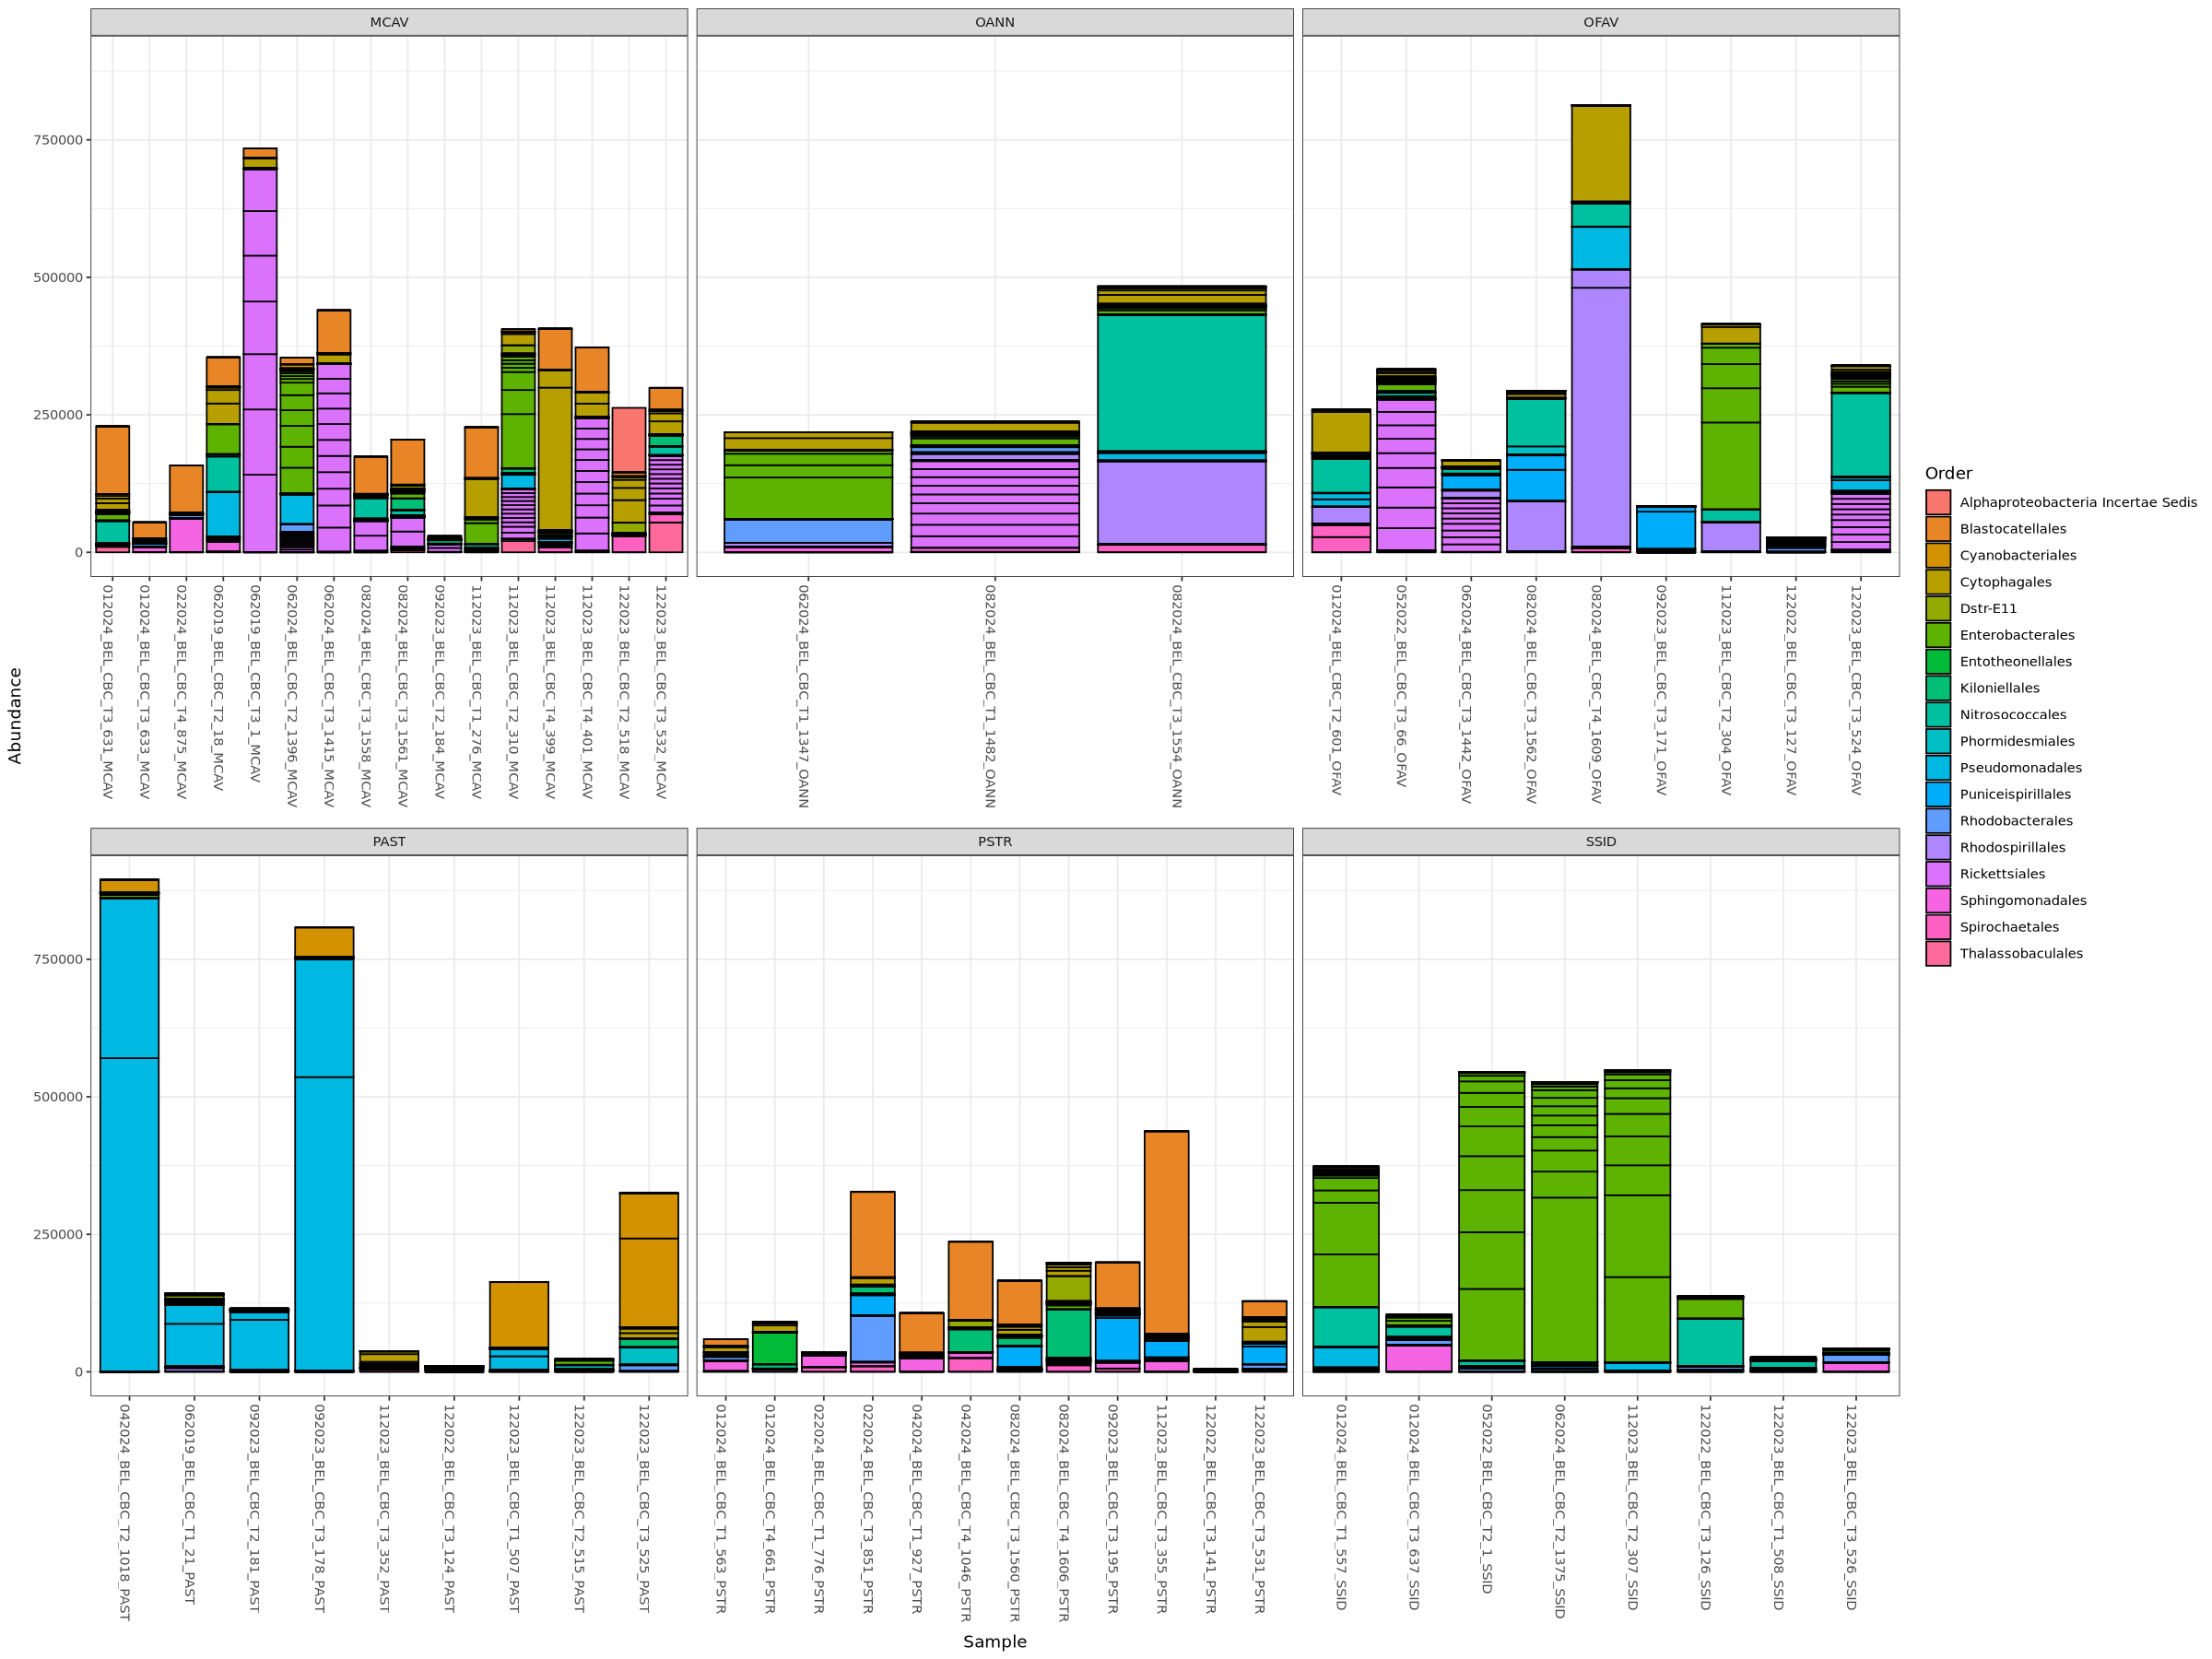

In [11]:
#plot after removing chloroplast
top100 <- names(sort(taxa_sums(ps_norm_nochlo), decreasing=TRUE))[1:100] 
#ps.top20 <- transform_sample_counts(ps_norm, function(OTU) OTU/sum(OTU)) 
ps.top100 <- prune_taxa(top100, ps_norm_nochlo) 
plot_bar(ps.top100, fill="Order") + facet_wrap(~species, scales="free_x")

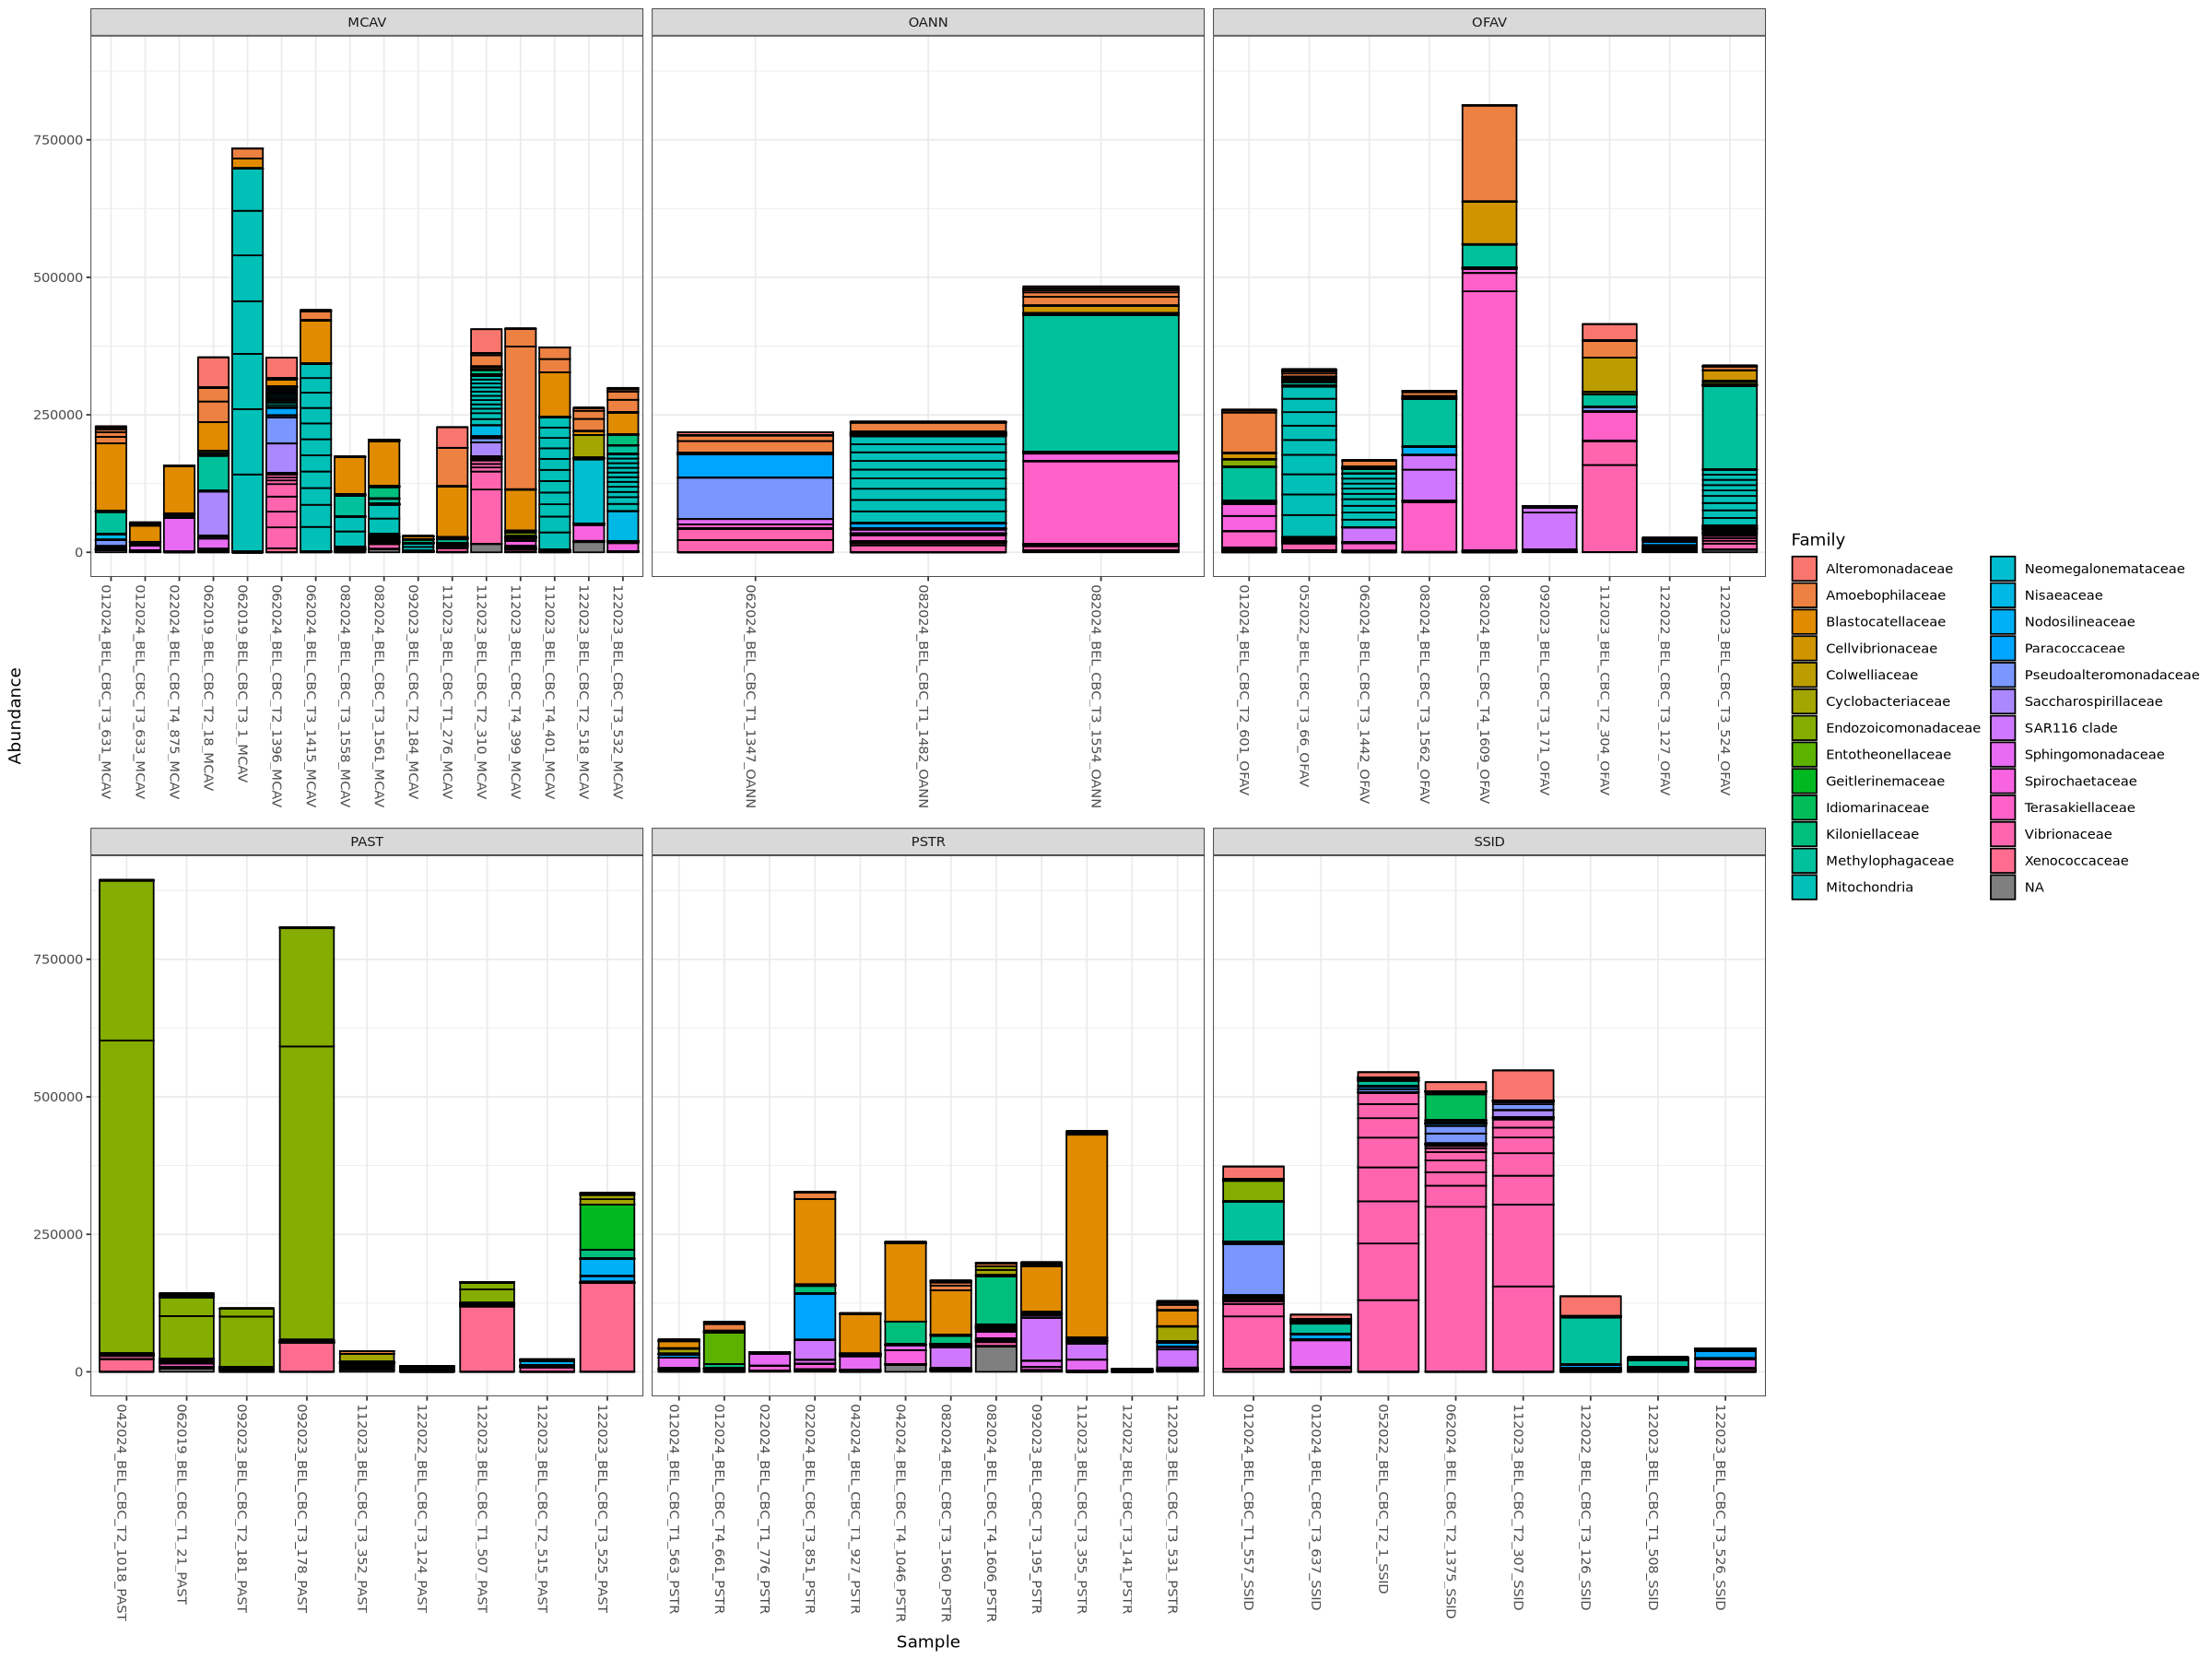

In [12]:
#plot after removing chloroplast
top100_nochlo <- names(sort(taxa_sums(ps_norm_nochlo), decreasing=TRUE))[1:100] 
#ps.top20 <- transform_sample_counts(ps_norm, function(OTU) OTU/sum(OTU)) 
ps.top100_nochlo <- prune_taxa(top100_nochlo, ps_norm_nochlo) 
plot_bar(ps.top100_nochlo, fill="Family") + facet_wrap(~species, scales="free_x")

### remove mitochondria, I think is being overrep in MCAV and OANN family level

In [34]:
#remove mitochondria family
ps_norm_nomit=subset_taxa(ps_norm_nochlo, Family!="Mitochondria")
ps_norm_nomit

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 44609 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95314 sample variables ]
tax_table()   Taxonomy Table:    [ 44609 taxa by 6 taxonomic ranks ]

In [ ]:
plot_bar(ps_norm_nomit, fill="Phylum")+
geom_bar(aes(color=Phylum, fill=Phylum), stat="identity", position="stack")

In [10]:
#plot after removing chloroplast
top100_nomit <- names(sort(taxa_sums(ps_norm_nomit), decreasing=TRUE))[1:100] 
#ps.top20 <- transform_sample_counts(ps_norm, function(OTU) OTU/sum(OTU)) 
ps.top100_nomit <- prune_taxa(top100_nomit, ps_norm_nomit) 
plot_bar(ps.top100_nomit, fill="Family") + facet_wrap(~species, scales="free_x")

### great now test this but separate by colony

In [ ]:
#plot precleaned colony
top20_col <- names(sort(taxa_sums(ps_norm_nomit), decreasing=TRUE))[1:20] 
#ps.top20 <- transform_sample_counts(ps_norm, function(OTU) OTU/sum(OTU)) 
ps.top20_col <- prune_taxa(top20_col, ps_norm_nomit) 
plot_bar(ps.top20_col, x="date", fill="Family") + facet_wrap(~colony, scales = "free_x")

In [35]:
#clean up colony 
# convert the sample_data() within a phyloseq object to a vegan compatible data object
pssd2veg <- function(ps_norm_nomit) {
  sd_nomit <- sample_data(ps_norm_nomit)
  return(as(sd_nomit,"data.frame"))
}
#using phyloseq nmds plot no chloroplast
sample_nomit <- pssd2veg(ps_norm_nomit)

In [36]:
sample_nomit <- as.data.frame(sample_data(ps_norm_nomit))
#save sammple names as a column so tidy doesn't get rid of it during filtering
sample_nomit$SampleID <- rownames(sample_nomit)

In [37]:
# Return names which have more than one row of data
# Now filter
sample_clean <- sample_nomit %>%
  group_by(colony) %>%
  filter(n() != 1) %>%
  ungroup()

In [38]:
nrow(sample_nomit)
nrow(sample_clean)

[1] 57

[1] 42

In [39]:
sample_clean <- as.data.frame(sample_clean)
class(sample_clean)

Warning message in class(x) <- tibble_class:
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”


[1] "data.frame"

In [40]:
# Restore rownames
rownames(sample_clean) <- sample_clean$SampleID

In [41]:
head(rownames(sample_clean))
NROW(sample_names(ps_norm_nomit))

[1] "012024_BEL_CBC_T1_557_SSID" "012024_BEL_CBC_T1_563_PSTR"
[3] "012024_BEL_CBC_T3_631_MCAV" "012024_BEL_CBC_T3_633_MCAV"
[5] "012024_BEL_CBC_T3_637_SSID" "012024_BEL_CBC_T4_661_PSTR"

[1] 57

In [42]:
keep_samples <- rownames(sample_clean)
length(keep_samples)
#how many of the values in keep_samples exist in ps_norm_nomit
sum(keep_samples %in% sample_names(ps_norm_nomit))  # Should be 42

[1] 42

[1] 42

In [43]:
# Prune to keep only those samples
ps_clean <- prune_samples(sample_names(ps_norm_nomit) %in% keep_samples, ps_norm_nomit)

In [44]:
class(ps_clean)

[1] "phyloseq"
attr(,"package")
[1] "phyloseq"

In [45]:
nrow(sample_data(ps_clean))

[1] 42

In [46]:
all(rownames(sample_clean) %in% sample_names(ps_clean))

[1] TRUE

In [47]:
#take the filtered metadata I just worked on — with cleaned rows, and correct sample names — and replace the old sample data in ps_clean with this cleaned version
sd_clean <- phyloseq::sample_data(sample_clean)
sample_data(ps_clean) <- sd_clean
head(sample_data(ps_clean))

,Health_Status,colony,Date_16S,double_band,date_sampled,transect,species,MonthYear,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA,⋯,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGCCGTGGTGTGTTTGGAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTAATGATACGGCGACCACCGAGATCTACACAATTCCGGTCGTCGGCAGCGTCAGATGTGTATAAGAGACAGGT,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACGCATGTCTATCTGGTGTGGCGGGGTTTGTTTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGGCGGGGTGTGGTTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,input,filtered,denoisedF,denoisedR,merged,nonchim,SampleID
,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<fct>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
012024_BEL_CBC_T1_557_SSID,Healthy,1_3,3_4_2025,y,012024,T1,SSID,Jan 2024,580,0,⋯,0,0,0,189570,176082,171436,173162,142705,129120,012024_BEL_CBC_T1_557_SSID
012024_BEL_CBC_T1_563_PSTR,Healthy,1_12,3_6_2025,,012024,T1,PSTR,Jan 2024,0,0,⋯,0,0,0,98511,89332,88739,88868,87695,44586,012024_BEL_CBC_T1_563_PSTR
012024_BEL_CBC_T3_631_MCAV,Healthy,3_21,3_4_2025,,012024,T3,MCAV,Jan 2024,328,0,⋯,0,0,0,536790,497421,495886,496193,481028,404924,012024_BEL_CBC_T3_631_MCAV
012024_BEL_CBC_T3_633_MCAV,Healthy,3_2,3_6_2025,,012024,T3,MCAV,Jan 2024,0,0,⋯,0,0,0,163169,154836,154032,153929,151918,62656,012024_BEL_CBC_T3_633_MCAV
012024_BEL_CBC_T3_637_SSID,Healthy,3_5,3_6_2025,,012024,T3,SSID,Jan 2024,0,128,⋯,0,0,0,22749,21151,20332,20453,19464,17819,012024_BEL_CBC_T3_637_SSID
012024_BEL_CBC_T4_661_PSTR,Healthy,4_98,3_6_2025,y,012024,T4,PSTR,Jan 2024,0,190,⋯,0,0,0,464328,426848,421862,422442,405813,369299,012024_BEL_CBC_T4_661_PSTR


### plotting no mitochondrial taxa, with cleaned colony data, using tax_glom

In [48]:
ps_clean_glom=tax_glom(ps_clean, taxrank="Family")

In [49]:
top100_col_glom <- names(sort(taxa_sums(ps_clean_glom), decreasing=TRUE))[1:100] 
#ps.top20 <- transform_sample_counts(ps_norm, function(OTU) OTU/sum(OTU)) 
ps_clean_glom_top100 <- prune_taxa(top100_col_glom, ps_clean_glom) 

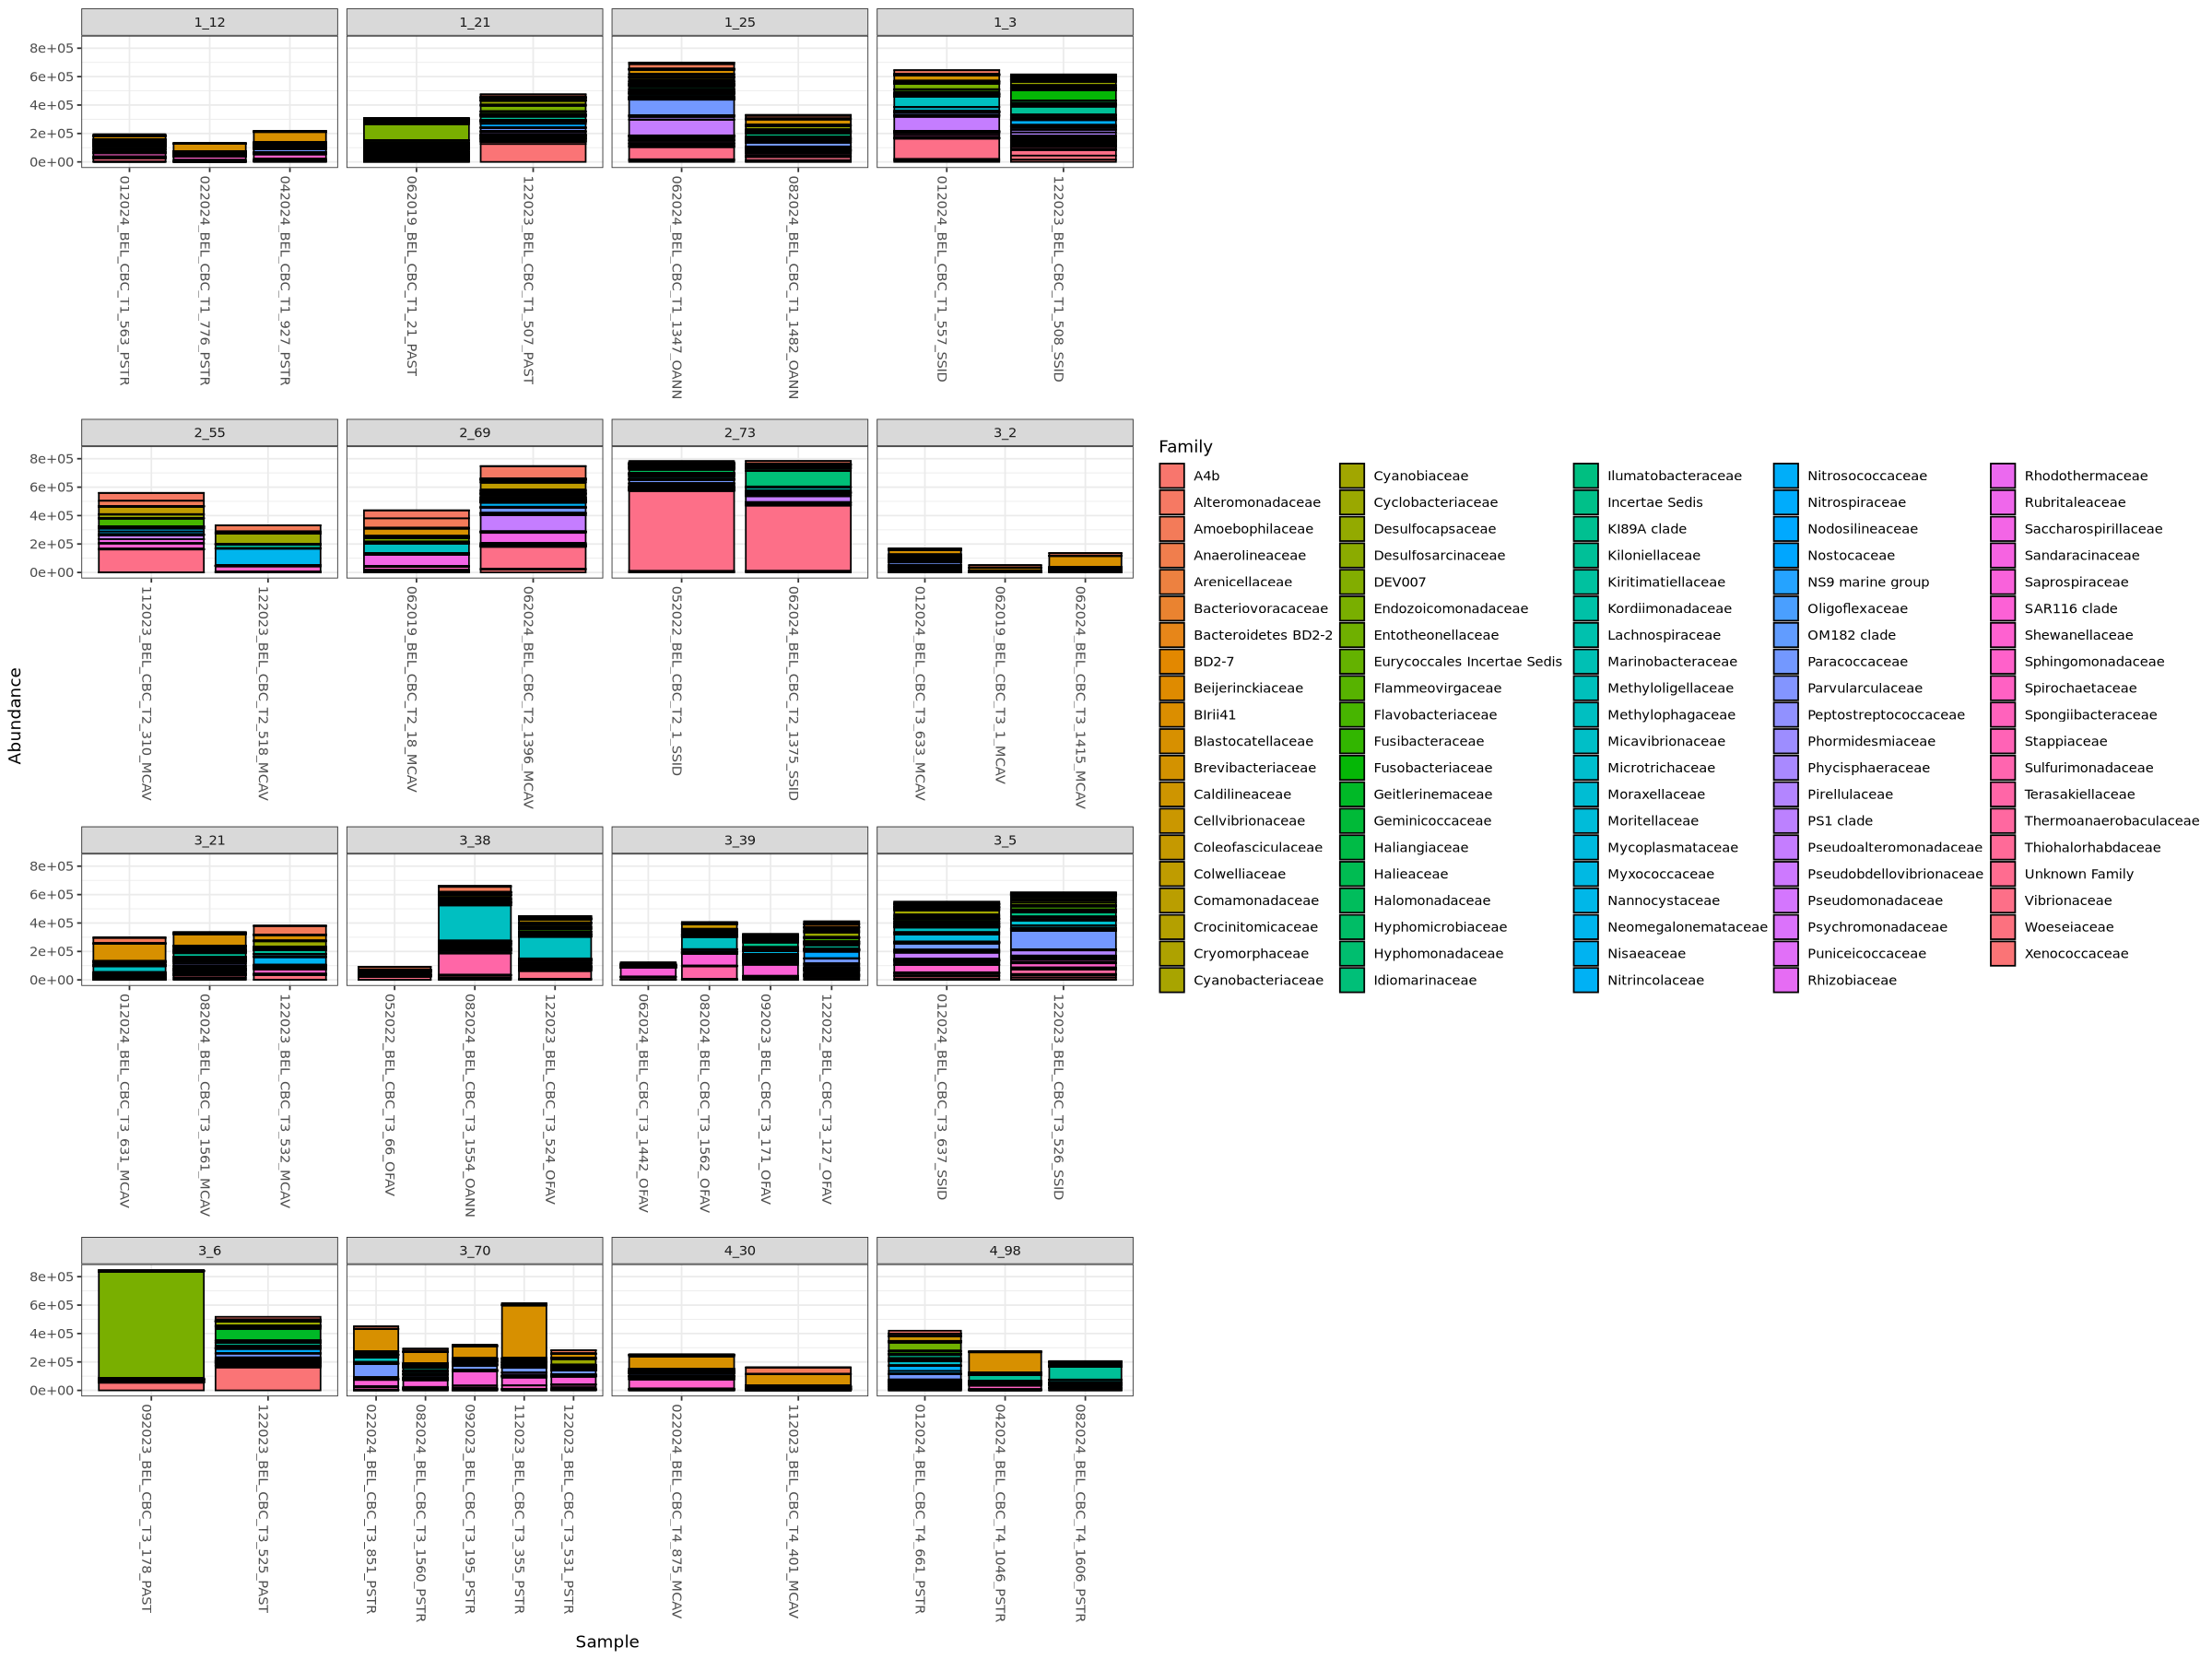

In [50]:
plot_bar(ps_clean_glom_top100, fill="Family")+ facet_wrap(~colony, scales="free_x")

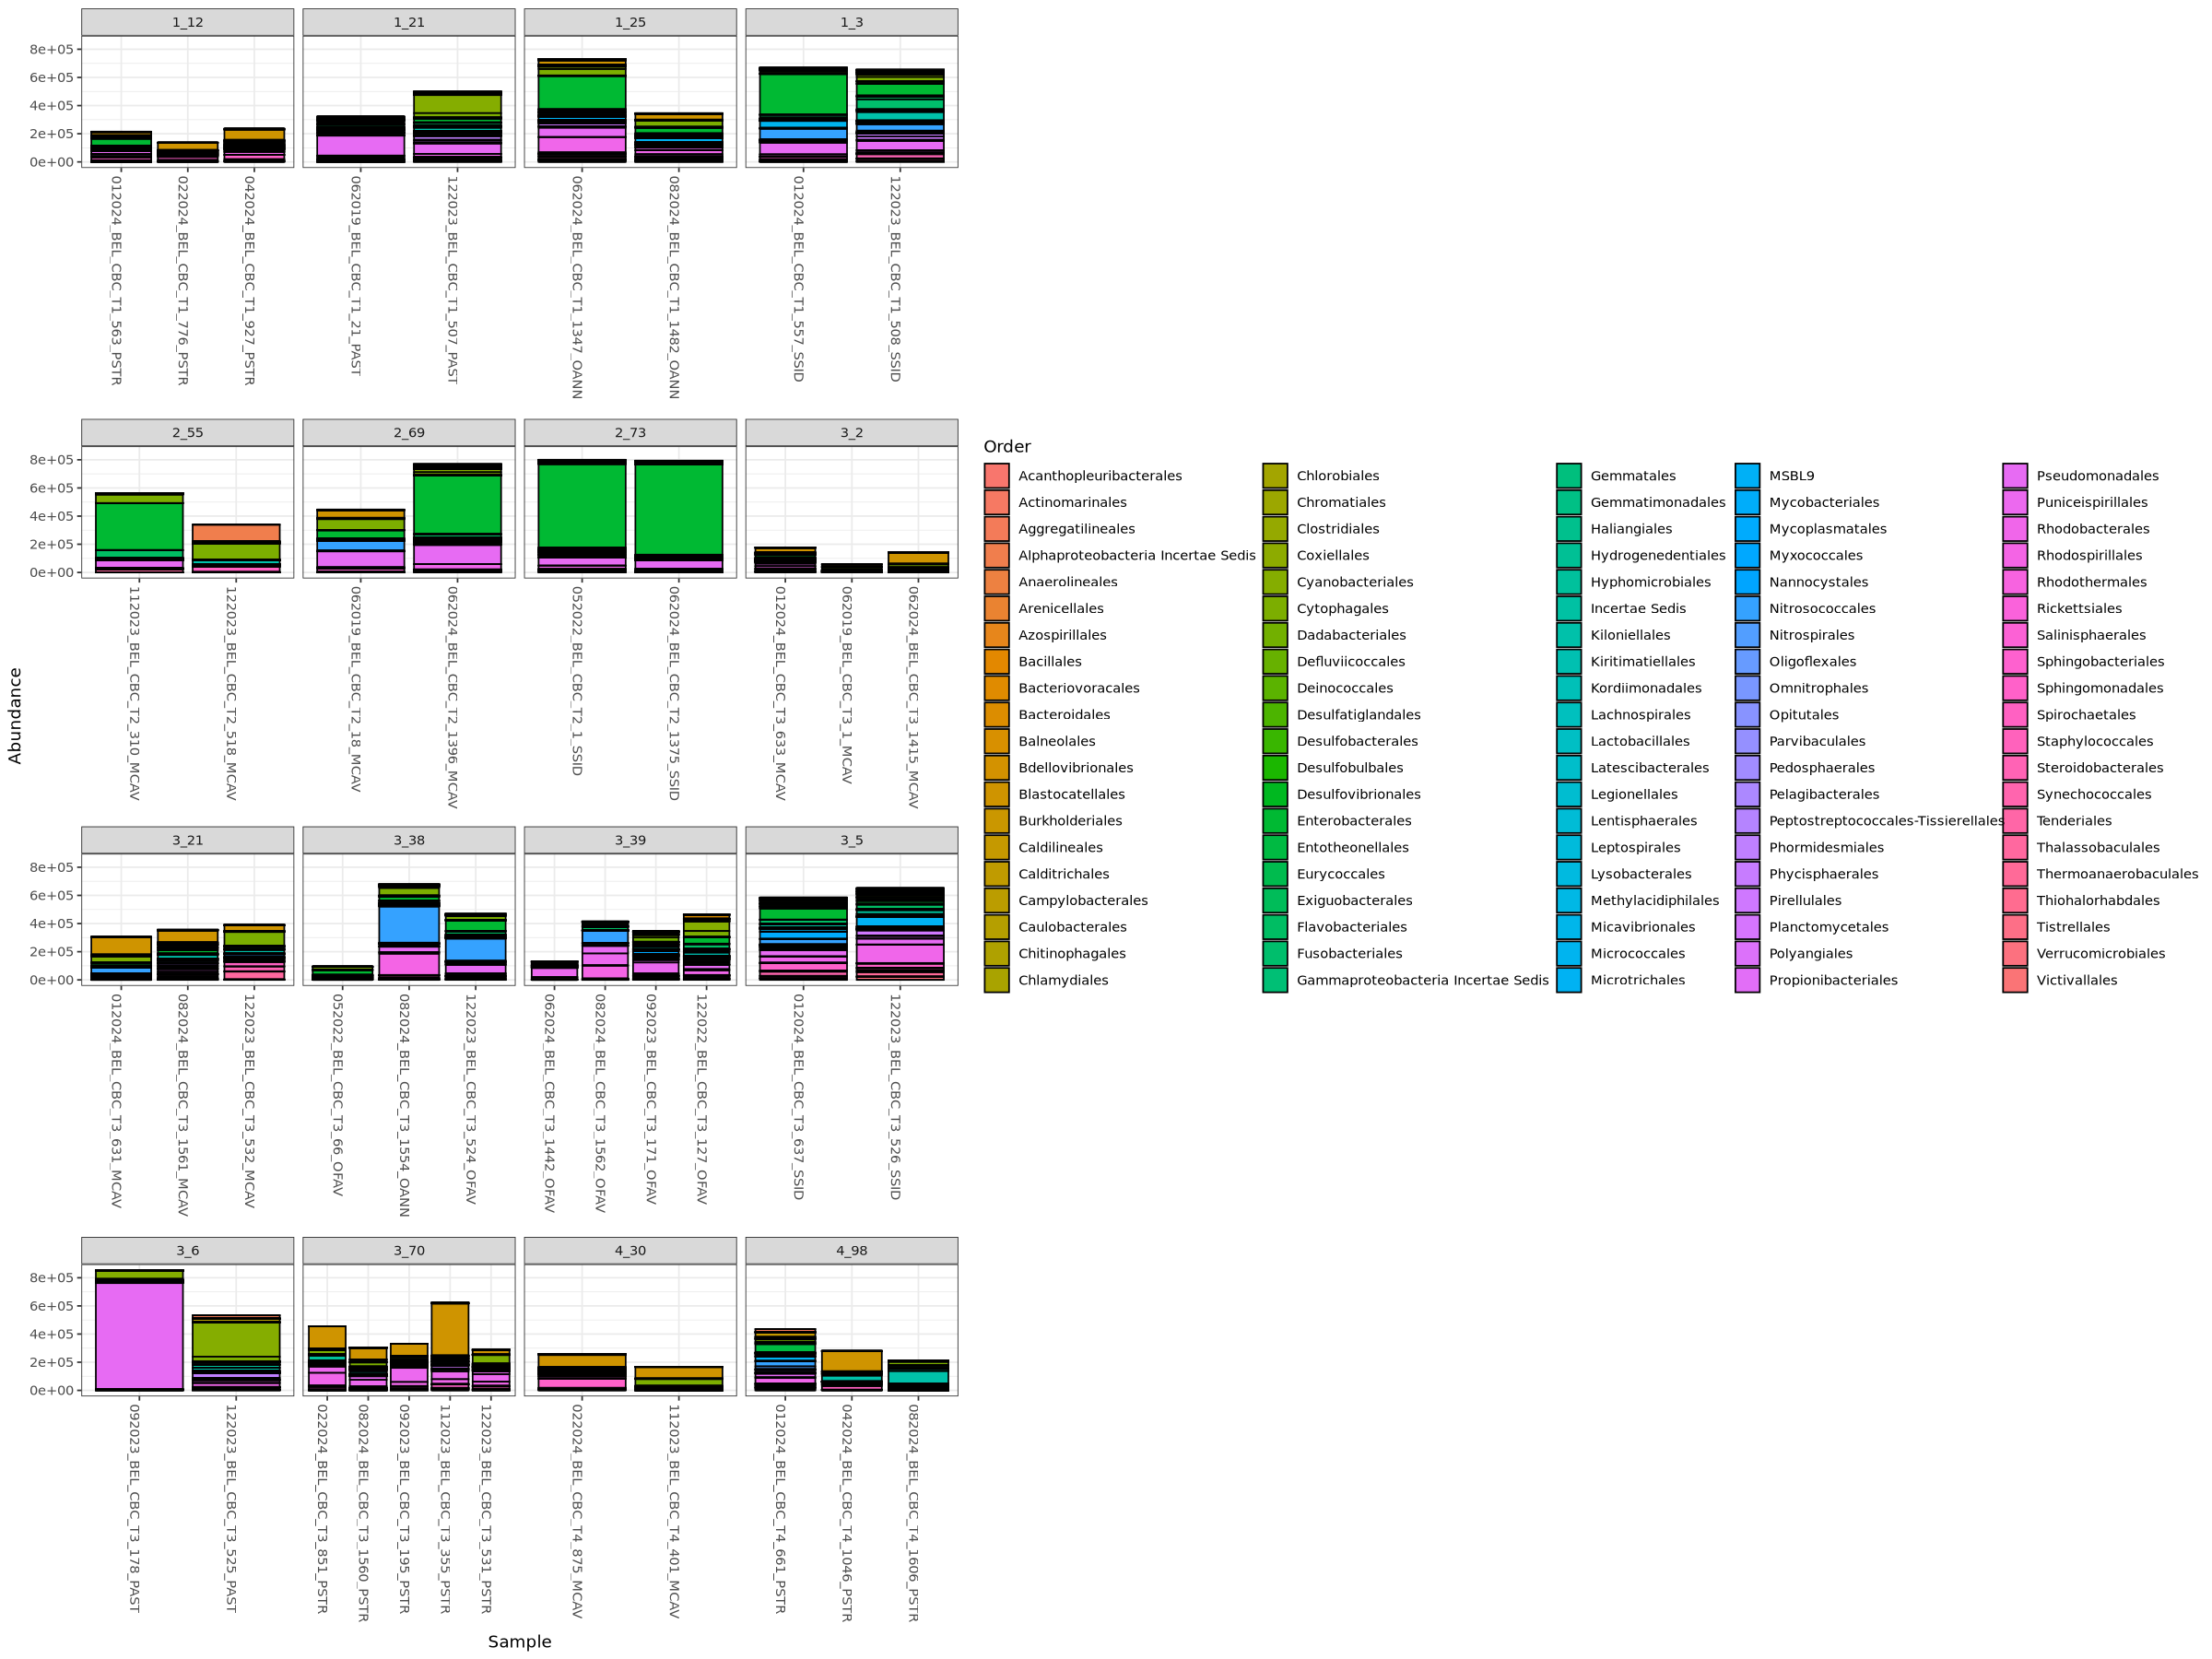

In [51]:
ps_clean_ord=tax_glom(ps_clean, taxrank="Order")

top100_col <- names(sort(taxa_sums(ps_clean_ord), decreasing=TRUE))[1:100] 
top100 <- prune_taxa(top100_col, ps_clean_ord) 
plot_bar(top100, fill="Order")+ facet_wrap(~colony, scales="free_x")

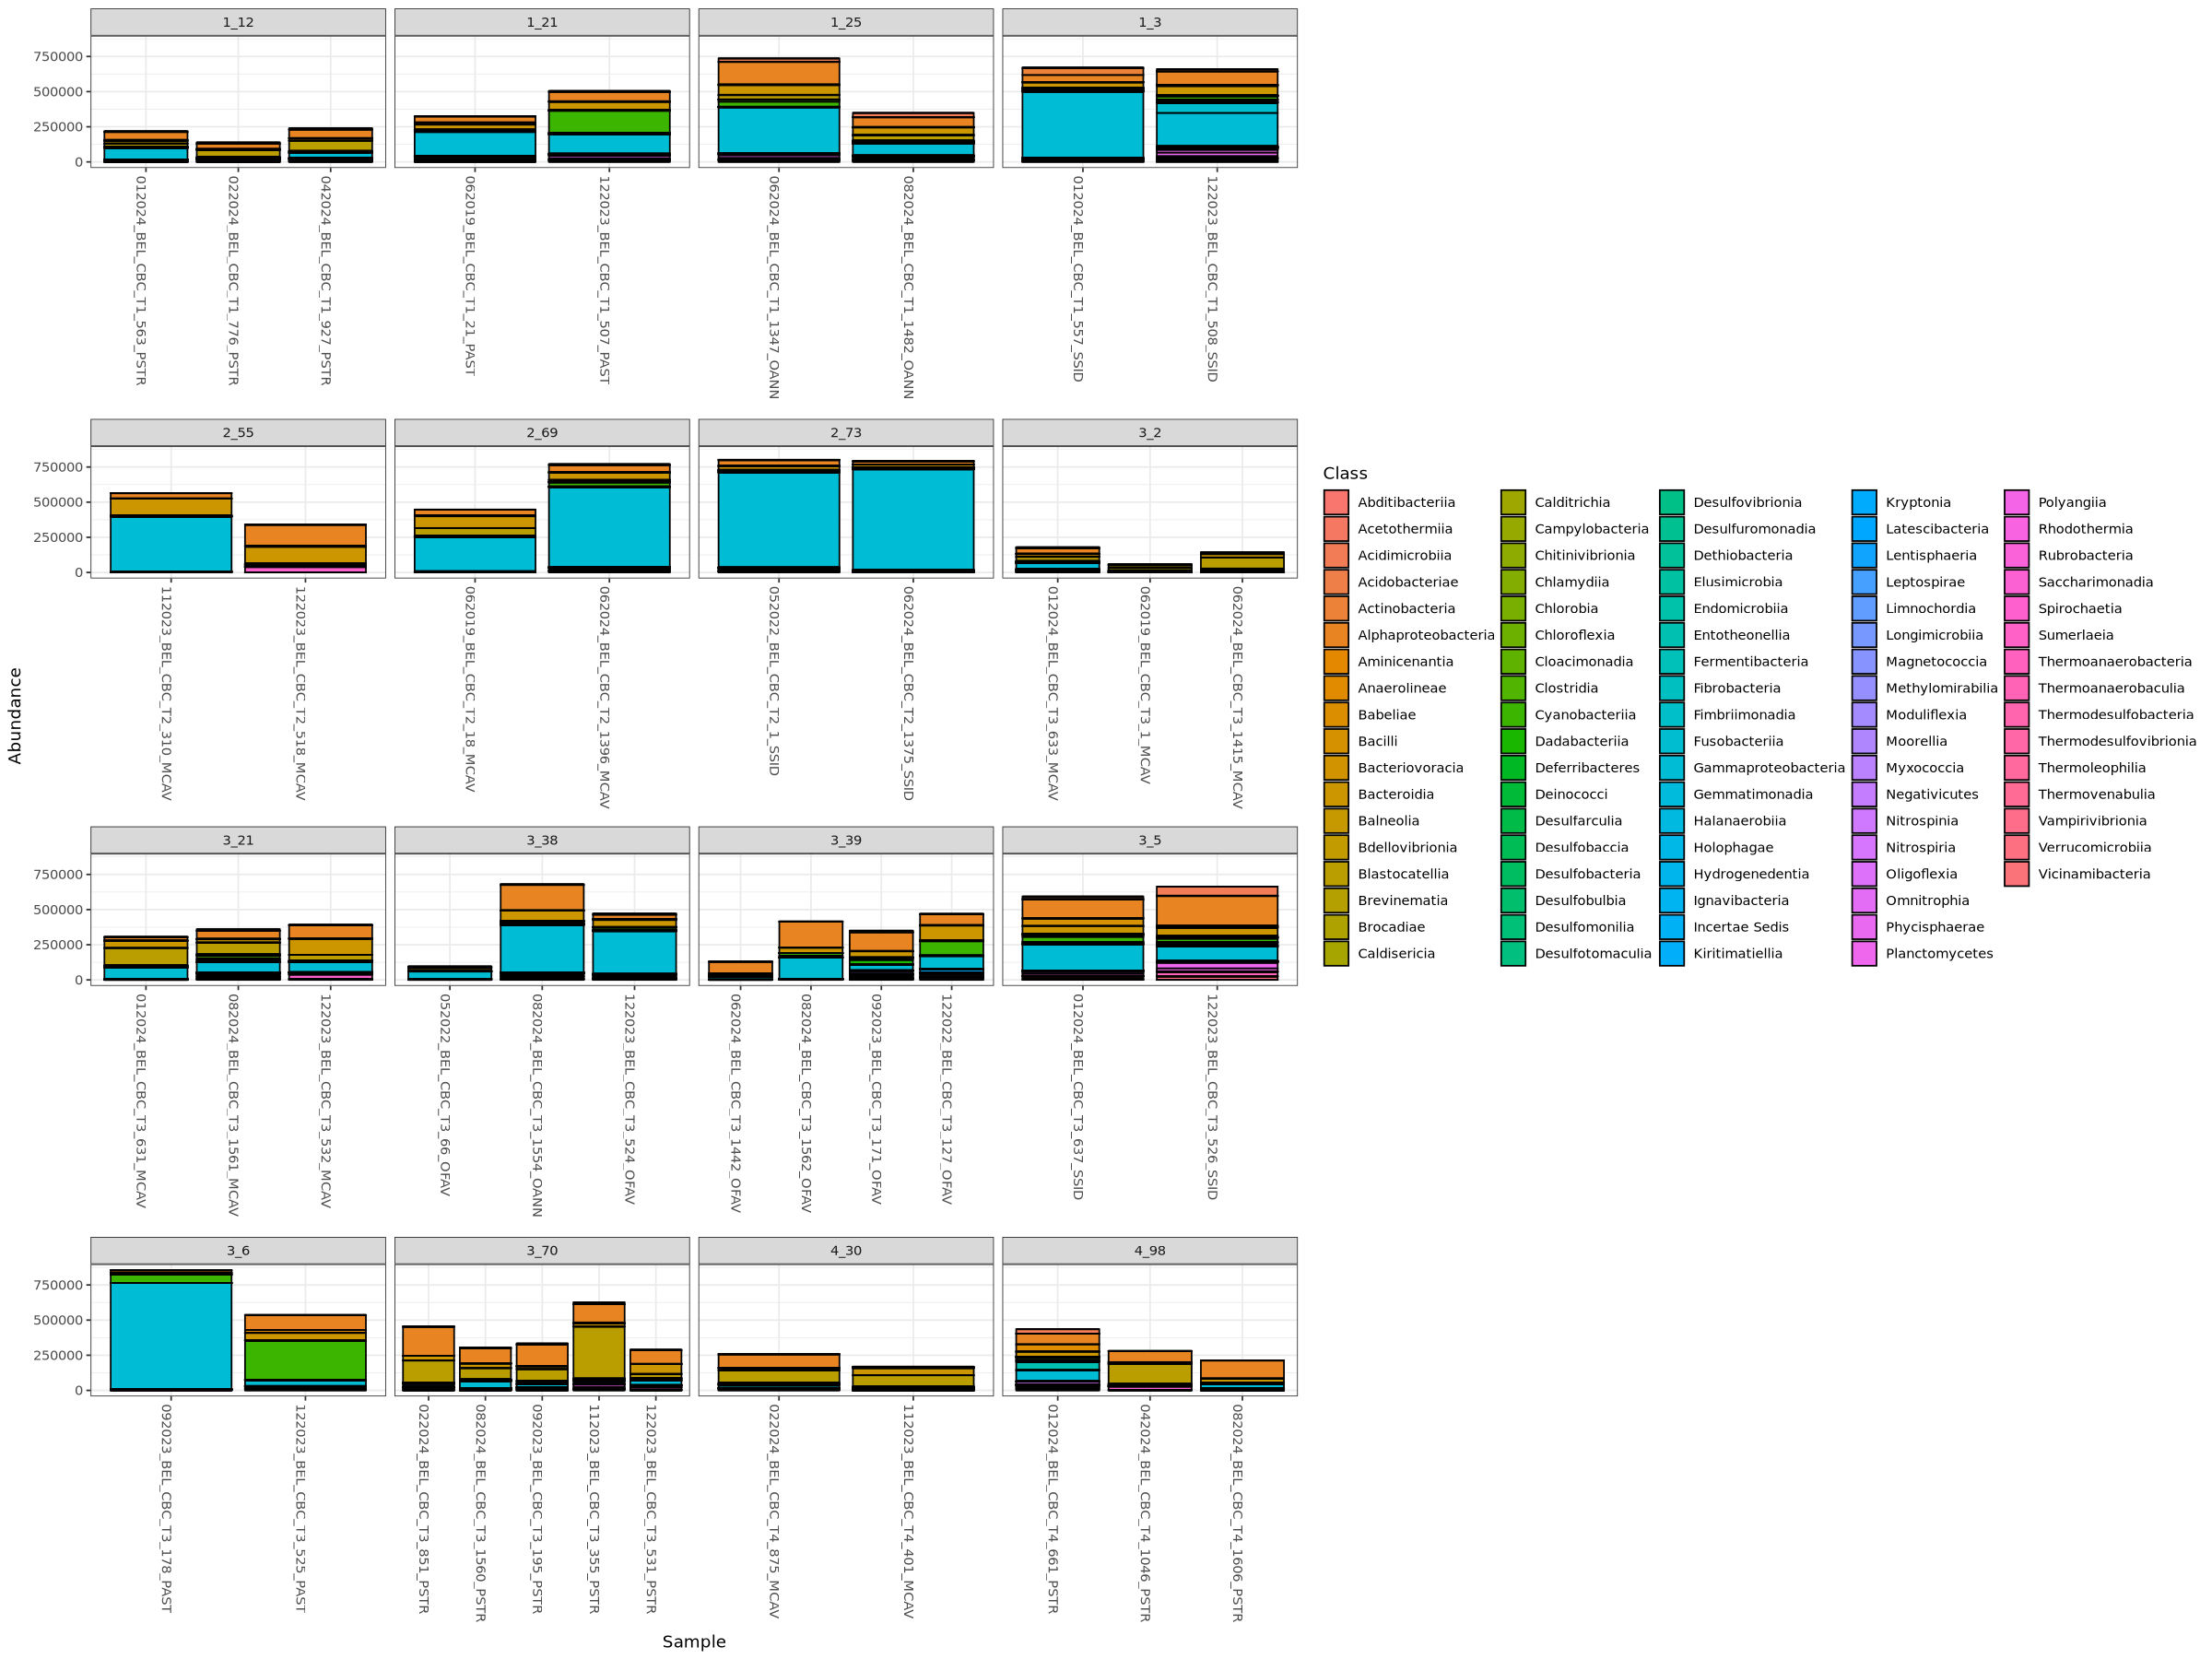

In [53]:
ps_clean_cl=tax_glom(ps_clean, taxrank="Class")

top100_col <- names(sort(taxa_sums(ps_clean_cl), decreasing=TRUE))[1:100] 
top100 <- prune_taxa(top100_col, ps_clean_cl) 
plot_bar(top100, fill="Class")+ facet_wrap(~colony, scales="free_x")